# Testing for Differences between Groups of Edges

Let's recall back to our school example. We have a network consisting of $100$ students who attend one of two schools, with the first $50$ students attending school one and the second $50$ students attending school two. The nodes are students, and the edges are whether a pair of students attend the same school. What we want to know is whether there is a higher chance two students are friends if they go to the same school than if they go to two different schools. We don't know which student goes to which school, so we have some work to do. The network is given to us looking something like this:

In [1]:
from graspologic.simulations import sbm
import numpy as np

# define the parameters for the SBM
ns = [50, 50]
n = np.array(ns).sum()
B = [[0.6, 0.3],[0.3, 0.6]]
ys = [1 for i in range(0, ns[0])] + [2 for i in range(0, ns[1])]

A = sbm(n=[50, 50], p=B, loops=False, directed=False)

# generate a reordering of the n nodes
vtx_perm = np.random.choice(n, size=n, replace=False)
Aperm = A[tuple([vtx_perm])] [:,vtx_perm]
yperm = np.array(ys)[vtx_perm]

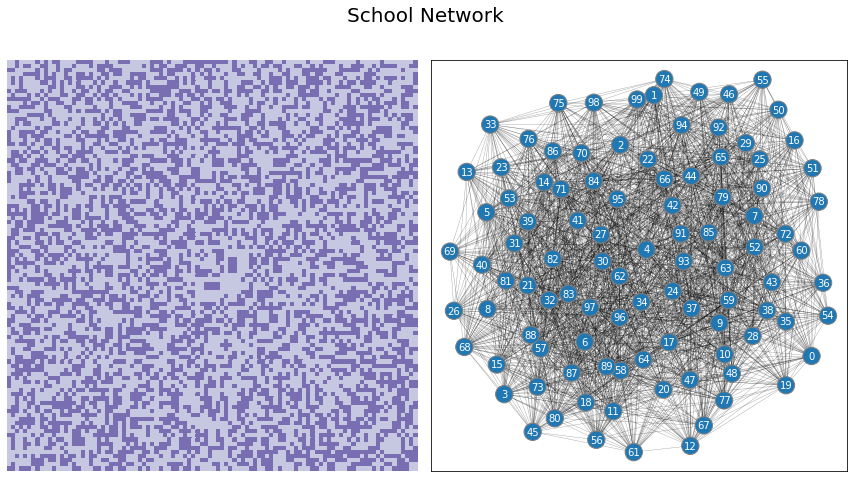

In [2]:
from graphbook_code import draw_multiplot
import matplotlib.pyplot as plt

draw_multiplot(Aperm, title="School Network");

The true, but *unknown*, probability matrix looks something like this:

In [3]:
z = np.array([[1, 0] for i in range(0, ns[0])] + [[0, 1] for i in range(0, ns[1])])
P = z @ B @ z.T

Pperm = P[tuple([vtx_perm])] [:,vtx_perm]

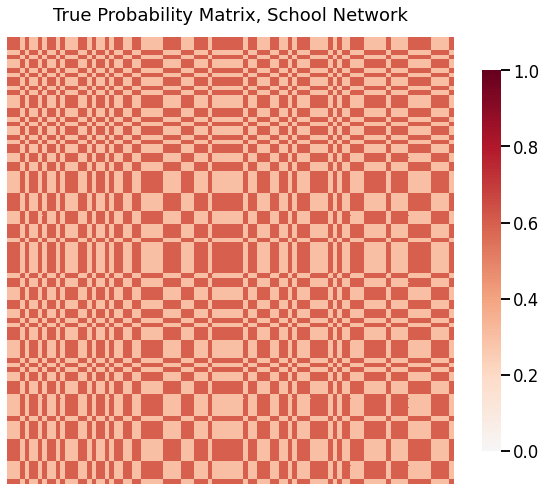

In [4]:
from graspologic.plot import heatmap

ax = heatmap(Pperm, vmin=0, vmax=1, title='True Probability Matrix, School Network')

How do we proceed? 

We begin by using spectral methods whichh were developed in [Chapter 6](#link?). Specifically, here we will use the adjacency spectral embedding, without specifying a number of embedding dimensions:

In [5]:
from graspologic.embed import AdjacencySpectralEmbed

ase = AdjacencySpectralEmbed()  # adjacency spectral embedding, with optimal number of latent dimensions selected using elbow picking
Xhat = ase.fit_transform(Aperm)

We visualize the estimated latent positions using a pairs plot:

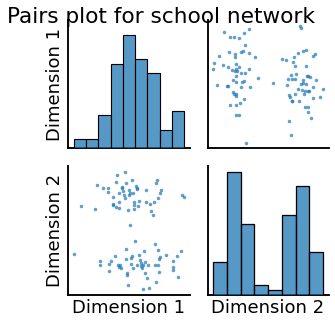

In [6]:
from graspologic.plot import pairplot

_ = pairplot(Xhat, title="Pairs plot for school network")

It seems pretty obvious that thhere are two distinct communities indicated by the latent positions, which makes sense given that there are students from two schools present. This is indicated in two off-diagonal plots, as we can see that in the upper-right plot for instance, the second latent dimension separates two clusters of latent positions approximately right down the middle. `K-means` picks up on this trend, too:

In [7]:
from graspologic.cluster import KMeansCluster

km_clust = KMeansCluster(max_clusters = 10)
km_clust = km_clust.fit(Xhat);

We start by visualizing the number of clusters produced by `K-means`, using the silhouette score:

In [8]:
nclusters = range(2, 11)  # graspologic nclusters goes from 2 to max_clusters
silhouette = km_clust.silhouette_  # obtain the respective silhouette scores

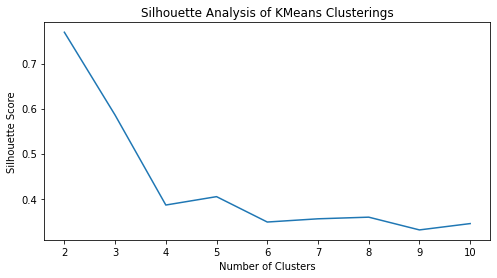

In [9]:
import seaborn as sns
from pandas import DataFrame as df

silhouette_df = df({"Number of Clusters": nclusters, "Silhouette Score": silhouette})  # place into pandas dataframe

fig, ax = plt.subplots(1,1,figsize=(8, 4))

sns.lineplot(data=silhouette_df,ax=ax, x="Number of Clusters", y="Silhouette Score");
ax.set_title("Silhouette Analysis of KMeans Clusterings")
fig;

It i clear that the silhouette score is maximized for $K=2$ clusters, so `K-means` has indicated that there are two clusters in the latent positions, and consequently two communities of nodes. Next, we produce community estimates for each of the nodes according to their latent positions. Further, since this example is a simulated network, we can also re-align the predicted labels with the true labels. Finally, we computer the overall quality of the clustering using the Adjusted Rand Index, and we visualize the node predictions:

In [10]:
from graspologic.utils import remap_labels
from sklearn.metrics import adjusted_rand_score

labels_autokmeans = km_clust.fit_predict(Xhat)
labels_autokmeans = remap_labels(yperm, labels_autokmeans)

ari_kmeans = adjusted_rand_score(labels_autokmeans, yperm)

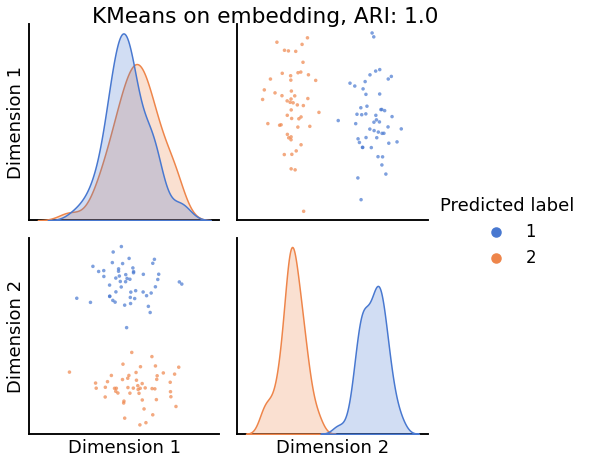

In [11]:
pairplot(Xhat,
         labels=labels_autokmeans,
         title=f'KMeans on embedding, ARI: {str(ari_kmeans)[:5]}',
         legend_name='Predicted label',
         height=3.5,
         palette='muted',);

Since the ARI is $1.0$, `K-means` has perfectly predicted which community each node is assigned to. Finally, let's take the original adjacency matrix, and just resort the nodes based on the predicted node communities:

In [12]:
# use argsort to sort by the kmeans labels
node_order = np.argsort(labels_autokmeans)

# resort the adjacency matrix
Asrt = Aperm[tuple([node_order])][:,node_order]
ysrt = labels_autokmeans[node_order]

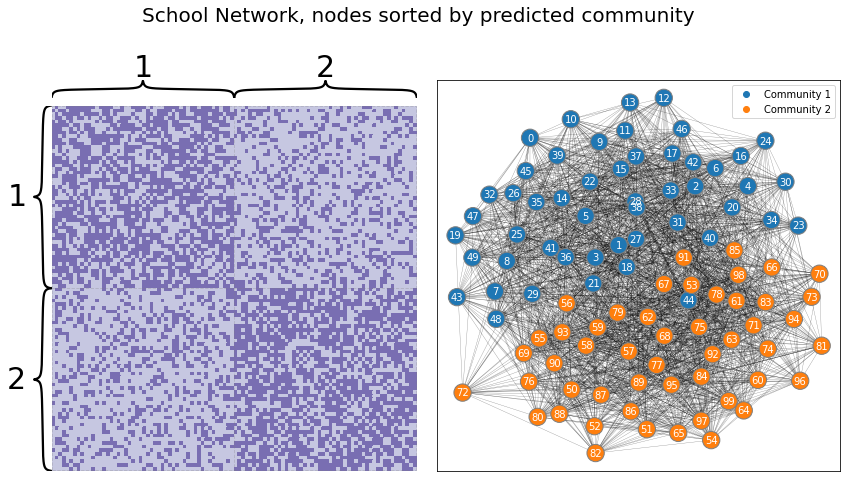

In [13]:
draw_multiplot(Asrt, labels=ysrt, title="School Network, nodes sorted by predicted community");

So, our question of interest is whether the within-school connectivity exceeds the between-school connectivity. Let's think of how to better formulate this problem.

Notice that the edges amongst students of school one are all in the upper left square of the adjacency matrix, and the edges amongst students of school two are all in the lower right square of the adjacency matrix. We will call these edges the "within-school" edges (Cluster $1$). The edges between students of school one and two are in the upper right and upper left squares of the adjacency matrix (Cluster $2$). In a picture, the edges are grouped as follows:

In [14]:
Z = np.chararray((n,n), itemsize=20)

Z[0:50,0:50] = 1  # within-school edge
Z[0:50,50:100] = 2  # between-school edge
Z[50:100,50:100] = 1  # within-school edge
Z[50:100,0:50] = 2  # between-school edge

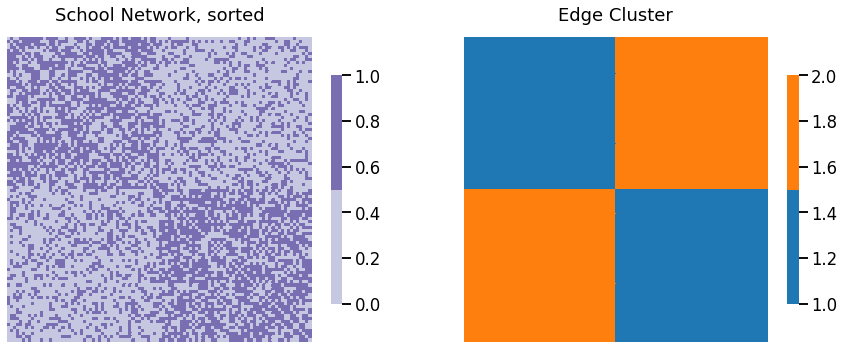

In [15]:
from graphbook_code import heatmap, cmaps

fig, ax = plt.subplots(1,2,figsize=(15, 6))

heatmap(Asrt, ax=ax[0], title='School Network, sorted')
heatmap(Z, ax=ax[1], color="qualitative", title="Edge Cluster");

So now, we know which cluster each edge is in, and we have a realization of a network. Recall that our original question was whether the indivduals within-school (cluster $1$) were better friends than individuals between-schools (cluster $2$). Reformulating this question in terms of the network, our question becomes whether the edges which are assigned to cluster $1$ have a *higher* probability of existing than the edges of cluster $2$. For this purpose, we introduce a *different* generalization of the Stochastic Block Model, the *Structured Independent Edge Model* (SIEM).

## The Structured Independent Edge Model is parametrized by a Cluster-Assignment Matrix and a probability vector

To describe the Structured Independent Edge Model (SIEM), we will return to our old coin flipping example.

### The Cluster-Assignment Matrix

The cluster assignment matrix $Z$ is an $n \times n$ matrix which assigns potential edges in the random network to clusters. What do we mean by this?

Remember that the adjacency matrix $\mathbf A$ for a random network is *also* an $n \times n$ matrix, where each entry $\mathbf a_{ij}$ is a random variable which takes the value $0$ or the value $1$ with a particular probability. The cluster assignment matrix takes each of these $n^2$ random variables, and uses a parameter $z_{ij}$ to indicate which of $K$ possible clusters this edge is part of. In the school example, for instance, the edges in the upper left and lower right are in cluster $1$ ('within-school' edges), and the edges in the upper right and lower left are in cluster $2$ ('between-school' edges). In the school example, $K=2$.

### The Probability vector

the second parameter for the SIEM is a probability vector, $\vec p$. If there are $K$ edge clusters in the SIEM, then $\vec p$ is a length-$K$ vector. Each entry $p_k$ indicates the probablity of an edge in the $k^{th}$ cluster existing in the network. For example, $p_1$ indicates the probability of an edge in the first edge cluster, $p_2$ indicates the probability of an edge in the second edge cluster, so on and so-forth. In the school example, for instance, the probability $p_1$ indicates the probability of a within-school edge, and the probability $p_2$ indicates the probability of a between-school edge.

Like usual, we will formulate the SIEM using our old coin flip example. We begin by obtaining $K$ coins, where the $k^{th}$ coin has a chance of landing on heads of $p_k$, and a chance of landing on tails of $1 - p_k$. For each entry $\mathbf a_{ij}$, we identify the corresponding cluster $z_{ij}$ that this edge is in. Remember that $z_{ij}$ takes one of $K$ possible values. We flip the $z_{ij}$ coin, and if it lands on heads (with probability $p_{z_{ij}}$), the edge exists, and if it lands on tails (with probability $1 - p_{z_{ij}}$) the edge does not exist.

If $\mathbf A$ is an SIEM random network with $n$ nodes, the cluster assignment matrix $Z$, and the probability vector $\vec p$, we say that $\mathbf A$ is an $SIEM_n(Z, \vec p)$ random network.

### How do we simulate realizations from an $SIEM_n(Z, \vec p)$ random network?

The procedure below will produce for us a network $A$, which has nodes and edges, where the underlying random network $\mathbf A$ is an $SIEM_n(Z, \vec p)$ random network:

```{admonition} Simulating a realization from an $SIEM_n(Z, \vec p)$ random network
1. Determine a cluster assignment matrix $Z$ for each edge of the network. Each edge entry $z_{ij}$ can take one of $K$ possible values.
2. Determine a length-$K$ probability vector for each of the $K$ edge clusters.
3. For each of the $K$ clusters, obtain $K$ total weighted coins, where the $k^{th}$ coin lands on heads with probability $p_k$ and tails with probability $1 - p_k$.
4. For each edge $(i, j)$:
    * Denote $z_{ij}$ to be the cluster assignment of the potential edge between node $i$ and node $j$.
    * Flip the $z_{ij}$ coin, and if it lands on heads, the corresponding entry in the adjacency matrix $a_{ij}$ is $1$. If it lands on tails, the coresponding entry in the adjacency matrix $a_{ij}$ is $0$. 
5. The adjacency matrix we produce, $A$, is a realization of an $SIEM_n(Z, \vec p)$ random network.
```

## Why do we care about the SIEM?

Remember that our question boiled down to whether the edges which are assigned to cluster $1$ have a *higher* probability of existing than the edges of cluster $2$. In other words, we *hypothesize* that the edges assigned to cluster $1$ have a higher probability of existing than the edges of cluster $2$. In terms of the probability vector, what we are saying is that we think that $p_1 > p_2$. Obviously, we are wrong if $p_1 \leq p_2$. This type of statistical question is known as a *hypothesis test*. **Hypothesis testing** is an approach by which we formulate statistical questions and present approaches which, *using the data*, indicates how much the data supports or doess not support the statistical questions we asked (or, provide us with the ability to *infer* something). For this reason, hypothesis testing is often an essential component of *statistical inference*, which is the name given to the process of learning something from data using statistical models. 

The way hypothesis testing works is we call one hypothesis a *null hypothesis* and the other an *alternative hypothesis*. The **null hypothesis** is the hypothesis where, if true, indicates that we were *wrong* about what how we thought the system behaved. In our example data, the null hypothesis is that $p_1 \leq p_2$. We typically would write this out notationally as $H_0: p_1 \leq p_2$. The capital $H$ is used to denote that this is a hypothesis, and the little "$0$" is just to indicate "null". The **alternative hypothesis** is the hypothesis where, if true, indicates that we werer *correct* about how we thought the system behaved. In our example, the alternative hypothesis is that $p_1 > p_2$, which we write out as $H_A: p_1 > p_2$. Here, the subscript $A$ denotes that this is the alternative hypothesis. When describing our hypothesis, we say that we are testing $H_A: p_1 > p_2$ *against* $H_0: p_1 \leq p_2$. This is because a hypothesis test must specifically delineate the possible situations in which we are *right* (the alternative $H_A$) and when we are *wrong* (the null $H_0$). We perform statisical inference by looking at how well the data we are presented with supports, or reflects, the alternative hypothesis.

### Hypothesis Testing with coin flips

To describe how hypothesis testing works from an implementation perspective, we'll naturally return to coin flips. If you remember way back to the [Preface of Chapter 5](#link?), we introduced a game. The game was as follows: a gambler has a coin, and asks us to gamble one dollar. If the coin lands on heads, we obtain our dollar back, and an additional dollar. If the coin lands on tails, we lose our dollar. We get to observe $10$ random coin flips, and determine whether we want to play the game. 

As it turns out, if this coin has a probability of landing on heads greater than $0.5$, we will, over time, *make* money if we continue to play the game. If the coin has a probablity off landing on heads lesss than $0.5$, we will, over time, *lose* money if we continue to play the game. So, if we are going to play the game in a principled way, we want to be really sure that we are going to gain money by playing. How can we use hypothesis testing to use a little bit of math to determine whether we should play or not?

To begin, we need to delineate our hypotheses. Here, our question of interest is, should we play the game? Therefore, the alternative hypothesis is the one where we *should* play the game, or the coin has a probability greater than $0.5$. The null hypothesis is that we should *not* play the game, or the coin has a probability that is not greaterr than $0.5$. If we use $p$ to denote the probability that the gambler's coin lands on heads, we write this as $H_A: p > 0.5$, against the null hypothesis that $H_0: p \leq 0.5$.

Let's say that we observe $10$ coin flips, and we see that the coin lands on heads $6$ times. If we were to estimate the coin's probability of landing on heads, like we did in the [Preface of the Section on MLE](#link?), we would get that $\hat p = \frac{6}{10}$, or that our estimate $\hat p = 0.6$. It's pretty obvious that $\hat p$ is greater than $0.5$, so we should play the game, right?

The answer is a little more complicated than that. If you take a fair coin (one that is roughly equally likely to land on heads and tails) and flip it enough times, you will probably find a sequence of ten flips with six heads. We are scientists, after all, so we want to be *really* sure that if we play we are going to make money. In statistical speak, we want to be sure that if we play the game, there is a low chance that we are actually wrong. We want to know exactly what the chances are that, if we were *wrong*, we could still have seen the estimate $\hat p$ that we calculated. This is where a concept called a *p-value* comes into play. 

#### $p$-values tell us the chances of observing an outcome if the null hypothesis is true

To understand the $p$-value, we must first introduce a concept called a *test statistic*. A test-statistic is a fancy word for a data-derived quantity that summarizes our data with a single number which will be used for hypothesis testing. The test statistic should capture a property of the data that is relevant to our question of interest (here, the probability that the coin lands on heads), so it makes sense in our example to just use the estimate of the probability that the coin lands on heads as our test statistic. 

Next, we need to think about what types of values we would see from the test statistic if the null hypothesis were true. If the coin really had a probability of $0.5$ of landing on heads and we flipped it $10$ times, there is a non-zero probabaility that we would see all heads and our estimate would have been $1.0$, that we would see $9$ heads and $1$ tails and our estimate would have been $0.9$, so on and so-forth all the way to the outcome where we see only tails and our estimate would have been $0.0$. Which one we observed when watching the gambler flip the coin would come down to *random chance*, so we will use the random variable $\mathbf{\hat p}_0$ to describe this quantity. Specifically, $\mathbf{\hat p}_0$ is a random variable which takes values between $0$ and $1$ in $0.1$ probability increments. $\mathbf{\hat p}_0$'s probability of taking a given increment $k$ is equal to the probability that we would have estimated the probability to be $k$ if the null hypothesis (the coin is fair and lands on heads with probability $0.5$) were true. $\mathbf{\hat p}_0$ takes each increment with the following probabilities:

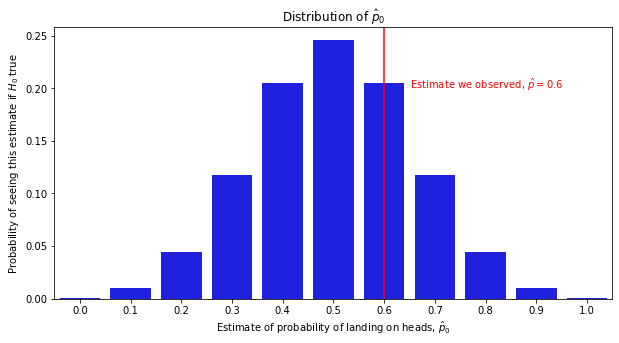

In [16]:
import seaborn as sns
import pandas as pd
from scipy.stats import binom
import warnings
warnings.filterwarnings("ignore")

incr = [i/10 for i in range(0, 11)]
probs = [binom.pmf(k=i*10, n=10, p=0.5) for i in incr]

fig, ax = plt.subplots(1,1, figsize=(10, 5))
sns.barplot(incr, probs, color="blue", ax=ax);
ax.set_xlabel("Estimate of probability of landing on heads, $\hat p_0$")
ax.set_ylabel("Probability of seeing this estimate if $H_0$ true")
ax.set_title("Distribution of $\hat p_0$");
ax.axvline(6, color="red")
ax.text(6.5, .2, "Estimate we observed, $\hat p = 0.6$", color="red");

So, this is a little surprising! Even if the null hypothesis were true and the coin really landed on heads with a probability of $0.5$, there is still a pretty good chance we would observe a probability of at least $0.6$ if we were to flip a fair coin $10$ times. We describe this quantity using a $p$-value, which is the probability of seeing a test statistic at least as extreme as the one we calculated from our data if the null hypothesis were true. Here, the $p$-value is the probability that, if the coin were fair, we would produce an estimate of $0.6$, $0.7$, $0.8$, $0.9$, or $1.0$. This is the sum of all of the heights of the corresponding bars in the above plot, which turns out to be $0.377$. This approach is called the *binomial test*, which we can implement in python as follows:

In [22]:
from scipy.stats import binom_test

nheads = 6  # the number of heads in the experiment
nflips = 10  # the total number of coin flips in the experiment
p0 = 0.5  # the probability of the coin under the null hypothesis

print("p-value: {:.3f}".format(binom_test(nheads, nflips, p=p0, alternative="greater")))

p-value: 0.377


This means that, even if the coin were fair, we still would have produced an estimate of $0.6$ about $37.7\%$ of the time, and we would be *wrong* to play the game. This might be enough for you to play the game, but as scientists we usually like to be a little more confident than this when we report something. We use the term the "$\alpha$ of the test" to describe what an acceptable chance of being incorrect is for us. We can pick $\alpha$ to be anything we want really so long as decide this threshold before calculating the $p$-value. Usually, scientists choose $0.05$, which means that we want there to be less than a $5\%$ chance that we are wrong before making a decision. In other words, we look for a $p$-value that is less than $0.05$. 

#### Two-sample hypothesis testing with coins

Let's say after seeing the first game, you determine that a $37.7\%$ chance of being wrong is a little too risky for you. The gambler presents you with a new game. He has two coins this time, and will even let you pick which to use. You gamble one dollar, and if your coin comes up heads but his comes up tails, you get your dollar plus an additional dollar. If both coins land on heads or tails, you get your dollar back. If his coin comes up heads but your coin comes up tails, you lose your dollar. This time, you get to see the gambler flip each coin ten times before determining whether you want to play. The first coin lands on heads seven times, and the second coin lands on heads only once. If the first coin actually has a higher chance of landing on heads than his coin, you should play the game. Will you gamble this time?

To formalize this situation, we'll use similar notation to before. We'll call $p_1$ the probability that your coin lands on heads, and $p_2$ the probability that his coin lands on heads. Our alternative hypothesis here is $H_A: p_1 \neq p_2$, against the null hypothesis $H_0: p_1 = p_2$. A **two-sample test** is a test which is performed when we have two random samples, and we want to investigate whether there is a difference between the two random samples. Specifically here, we have the outcomes of coin flips from each of the two coins, and we want to determine whether the first coin is actually different from the second coin. Intuitionally, the idea is that even if the first coin did not have a higher probability of landing on heads than the second coin, there is still some probability that if we flipped each coin ten times, we would get more heads with the second coin. We see that our estimates of the probabailities are $\hat p_1 = \frac{7}{10} = 0.7$ and $\hat p_2 = \frac{1}{10} = 0.1$ respectively. 

When we have two samples of data whose outcomes boil down to ones and zeros (or, heads and tails), it turns out that the intuition gets more complex pretty quickly. For this reason, we won't explain the two-sample test for binary data in quite as muc depth as we did with the previous example (the **one-sample test**), but much of the same intuition holds. Again, we seek to compute a $p$-value which tells us the chances of observing that $\hat p_1 = 0.7$ and $\hat p_2 = 0.1$ if $p_1$ weren't actually greater than $p_2$. In this case, the appropriate statistical test is known as [Fisher's Exact Test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test), which we can implement using `scipy`. The inputs for Fisher's exact test is a contingency table of the results:

| | First coin | Second coin |
|---|---|---|
| Landed on heads | 7 | 1 |
| Landed on tails | 3 | 9 |

In [27]:
from scipy.stats import fisher_exact

table = [[7,3], [1,9]]
test_statistic, pval = fisher_exact(table)
print("p-value: {:.3f}".format(pval))

p-value: 0.020


This means that, there is only about a $2\%$ chance that the two coins have the same probability of landing on heads, as the $p$-value is $0.02$. If we were to again use $\alpha=0.05$ as our decision threshold, this means we should play this game as many times as the gambler will allow before he catches on.